## Handling the Data

#### Import packages

In [184]:
import os
import glob
import re
import random
import cv2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image


#### Extracting a subset of training data

In [185]:
def extract_realism_score(file_name):
    match = re.search(r'r(\d+\.\d+)_', file_name)
    if match:
        return float(match.group(1))
    else:
        print(f"Could not extract realism score from {file_name}")
        return None

example_filename = "r0.50_00228_05516.png"
print(f"Extracted realism score: {extract_realism_score(example_filename)}")


Extracted realism score: 0.5


In [186]:
def extract_dataset(dataset):
    image_paths = []

    for folder in dataset:
        if not os.path.exists(folder):
            print(f"The dataset path {folder} does not exist.")
        else:
            folder_images = glob.glob(os.path.join(folder, "*.png"))
            image_paths.extend(folder_images)
            print(f"Found {len(folder_images)} images in {folder}")

    print(f"Total images collected: {len(image_paths)}")
    return image_paths

toy_dataset = ["Flux+Real_10k 5/"]
image_paths = extract_dataset(toy_dataset)

Found 1279 images in Flux+Real_10k 5/
Total images collected: 1279


#### Visualizing few images

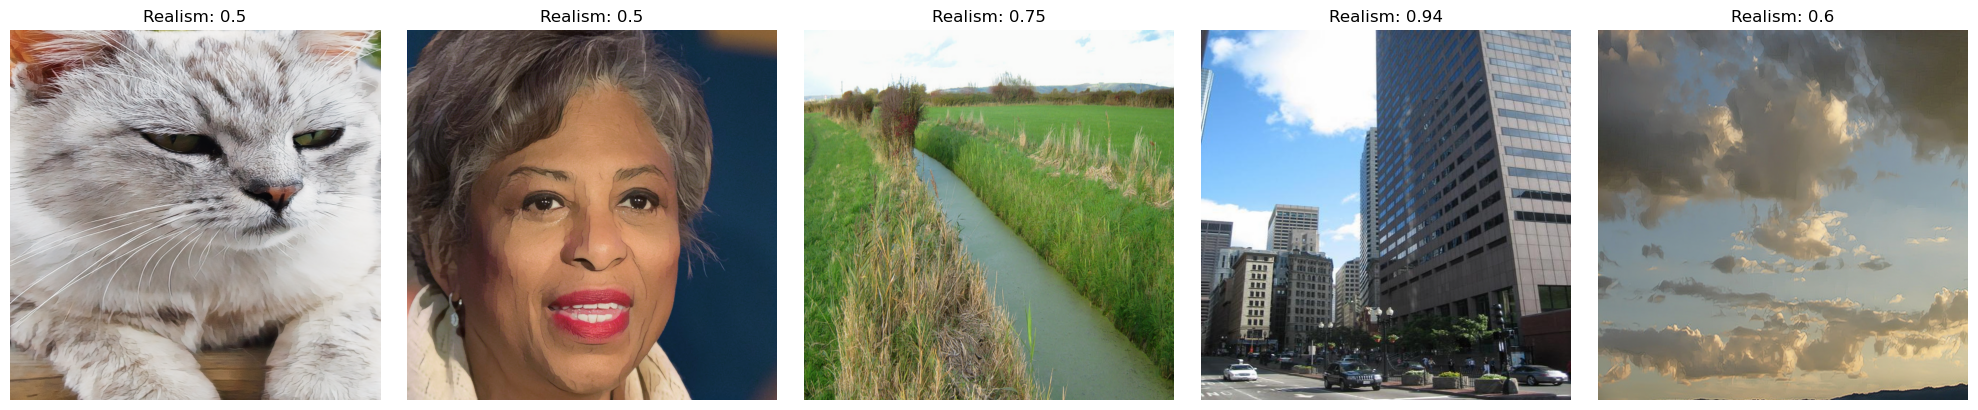

In [187]:
num_to_display = 5

fig, axes = plt.subplots(1, num_to_display, figsize=(20, 4))

for i in range(num_to_display):
    image_path = random.choice(image_paths)
    image = Image.open(image_path)    
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Realism: {extract_realism_score(os.path.basename(image_path))}")

plt.tight_layout()
plt.show()

## Data Preprocessing and Analysis

In [188]:
target_size = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def preprocess_image(image_path, target_size= target_size):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean= mean, std= std)
    ])
    return transform(image)

def denormalize_image(tensor, mean= mean, std= std):
    tensor = tensor.clone().detach().numpy()
    denormalized = tensor * np.array(std)[:, None, None] + np.array(mean)[:, None, None]
    clipped = np.clip(denormalized, 0, 1)
    return np.transpose(clipped, (1, 2, 0))


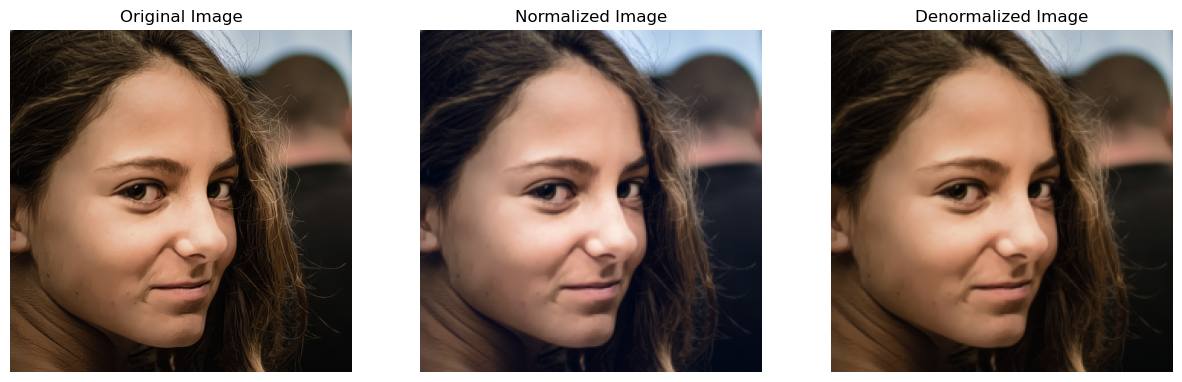

In [189]:
image_path = random.choice(image_paths)
original_image = Image.open(image_path).convert("RGB")
normalized_image = preprocess_image(image_path)
denormalized_image = denormalize_image(normalized_image)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

normalized_np = normalized_image.clone().detach().numpy()
normalized_np = np.transpose(normalized_np, (1, 2, 0))
axes[1].imshow((normalized_np - np.min(normalized_np)) / (np.max(normalized_np) - np.min(normalized_np))) 
axes[1].set_title("Normalized Image")
axes[1].axis("off")

axes[2].imshow(denormalized_image) 
axes[2].set_title("Denormalized Image")
axes[2].axis("off")

plt.show()


#### Plotting the distribution of realism scores in the dataset

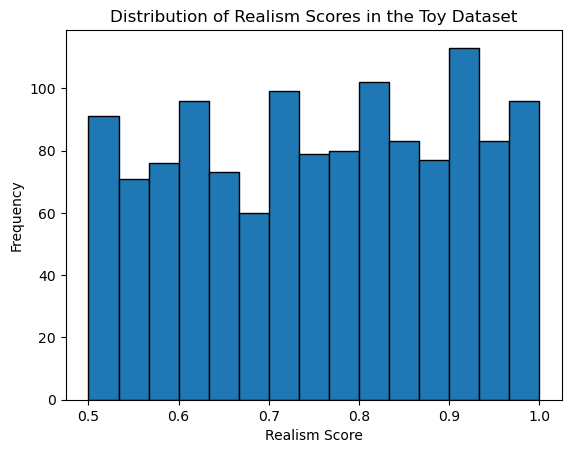

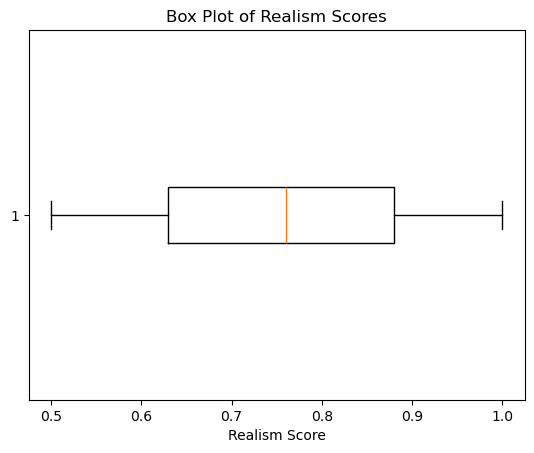

In [190]:
labels = []

for image_path in image_paths:
    score = extract_realism_score(os.path.basename(image_path))
    labels.append(score)

labels = np.array(labels)

plt.hist(labels, bins=15, edgecolor='black')
plt.xlabel('Realism Score')
plt.ylabel('Frequency')
plt.title('Distribution of Realism Scores in the Toy Dataset')
plt.show()

plt.boxplot(labels, vert=False)
plt.xlabel('Realism Score')
plt.title('Box Plot of Realism Scores')
plt.show()

#### Creating a dataset

In [191]:
class RealismDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = preprocess_image(image_path)
        realism_score = extract_realism_score(os.path.basename(image_path))
        realism_score = torch.tensor(realism_score, dtype=torch.float32)
        return image, realism_score


#### Training preparation

## Model Design

In [192]:
class RegressionResNet(nn.Module):
    def __init__(self, freeze_features= False):
        super(RegressionResNet, self).__init__()
        self.resnet = models.resnet18(weights= models.ResNet18_Weights.DEFAULT)

        if freeze_features:
            for param in self.resnet.parameters():
                param.requires_grad = False
        
        in_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.resnet(x)

In [193]:
model = RegressionResNet()
batch_size = 32
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
    
model.to(device)
print(f"Training on device: {device}")

Training on device: mps


In [194]:
train_paths, val_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
val_paths, test_paths = train_test_split(val_paths, test_size=0.5, random_state=42)

print(f"Training images: {len(train_paths)} | Validation images: {len(val_paths)} | Testing images: {len(test_paths)}")

train_dataset = RealismDataset(train_paths)
val_dataset = RealismDataset(val_paths)

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size, shuffle=False)

Training images: 1023 | Validation images: 128 | Testing images: 128


## Training and Evaluation

In [195]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def evaluate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

In [196]:
def compute_metrics(model, loader, device):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            predictions.append(outputs.cpu())
            targets.append(labels.cpu())
    
    predictions = torch.cat(predictions, dim=0)
    targets = torch.cat(targets, dim=0)

    mse = nn.MSELoss()(predictions, targets).item()
    mae = nn.L1Loss()(predictions, targets).item()
    
    # Compute R-squared: 1 - SSE / SST
    sse = torch.sum((targets - predictions) ** 2).item()
    sst = torch.sum((targets - torch.mean(targets)) ** 2).item()
    r_squared = 1 - sse / sst if sst > 0 else 0
    return mse, mae, r_squared
    

In [197]:
training_losses = []
validation_losses = []
best_val_loss = float("inf")
early_stopping_patience = 7
early_stopping_counter = 0

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = evaluate_epoch(model, val_loader, criterion, device)
    mse, mae, r_squared = compute_metrics(model, val_loader, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")
    print(f"Val Metrics --> MSE: {mse:.4f} | MAE: {mae:.4f} | R2: {r_squared:.4f}")

    training_losses.append(train_loss)
    validation_losses.append(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

Epoch 1/20
Train Loss: 0.5592 - Val Loss: 120.3919
Val Metrics --> MSE: 120.3918 | MAE: 7.3694 | R2: -5613.8734
Epoch 2/20
Train Loss: 0.0357 - Val Loss: 0.0332
Val Metrics --> MSE: 0.0332 | MAE: 0.1438 | R2: -0.5487
Epoch 3/20
Train Loss: 0.0268 - Val Loss: 0.0568
Val Metrics --> MSE: 0.0568 | MAE: 0.1680 | R2: -1.6473
Epoch 4/20
Train Loss: 0.0299 - Val Loss: 0.1292
Val Metrics --> MSE: 0.1292 | MAE: 0.1778 | R2: -5.0276
Epoch 5/20
Train Loss: 0.0278 - Val Loss: 0.0237
Val Metrics --> MSE: 0.0237 | MAE: 0.1314 | R2: -0.1056
Epoch 6/20
Train Loss: 0.0236 - Val Loss: 0.0235
Val Metrics --> MSE: 0.0235 | MAE: 0.1309 | R2: -0.0961
Epoch 7/20
Train Loss: 0.0229 - Val Loss: 0.0253
Val Metrics --> MSE: 0.0253 | MAE: 0.1327 | R2: -0.1784
Epoch 8/20
Train Loss: 0.0245 - Val Loss: 0.0249
Val Metrics --> MSE: 0.0249 | MAE: 0.1333 | R2: -0.1597
Epoch 9/20
Train Loss: 0.0190 - Val Loss: 0.0239
Val Metrics --> MSE: 0.0239 | MAE: 0.1306 | R2: -0.1167
Epoch 10/20
Train Loss: 0.0227 - Val Loss: 0.026

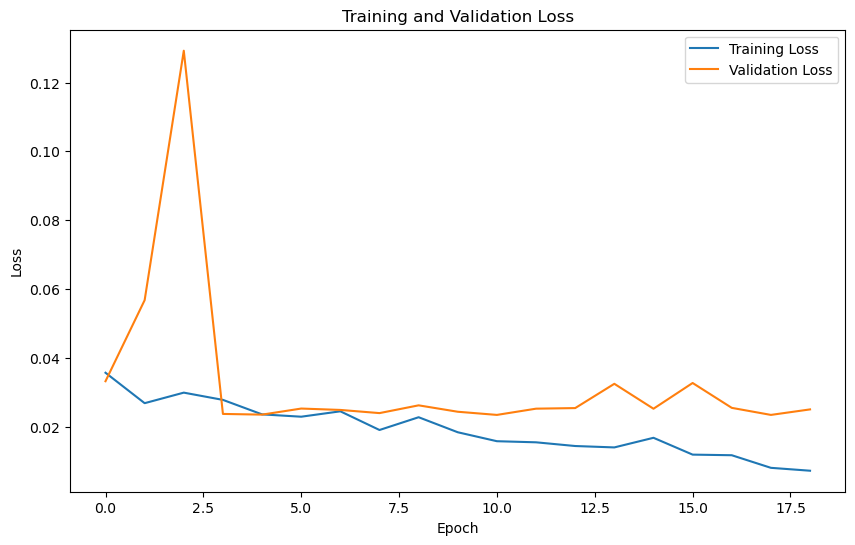

In [199]:
plt.figure(figsize=(10, 6))
plt.plot(training_losses[1:], label="Training Loss")
plt.plot(validation_losses[1:], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()